<a href="https://colab.research.google.com/github/azullah/DTSA5511_Week3_kaggle/blob/main/Histopathologic_Cancer_Detection_Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA - 5511 Deeplearning - Week 3 Kaggle Challenge
## Histopathologic Cancer Detection
### https://www.kaggle.com/c/histopathologic-cancer-detection/overview

This notebook contains the code for the Week 3 mini-project Histopathologic Cancer Detection from Kaggle.

The objective of the project is to detect Metastasis for Histopathologic Cancer, in the given dataset of input images. This will be treated as a binary classification problem,

#### From the Kaggle Project dataset description

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.



#### Get the data  
Copy and Unzip files from Google drive
The zip data file was earlier copied from the Kaggle project `histopathologic-cancer-detection` dataset to my personal google drive. [Instructions can be found here](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)

In [1]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive')

zip_path = '/gdrive/MyDrive/kaggle/histopathologic-cancer-detection.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'histopathologic-cancer-detection.zip'
# View the unzipped contents in the virtual machine
os.listdir()

Mounted at /gdrive
/content


['.config',
 'sample_submission.csv',
 'train',
 'test',
 'train_labels.csv',
 'histopathologic-cancer-detection.zip',
 'sample_data']

##### Import all required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

## Exploratory Data Analysis

### Read the Training labels file
This is a csv file with the image ID and the label.

*Note: The image files are .tif files with the image ID as their name*

In [3]:
train = pd.read_csv('./train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [4]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train.id = train.id + '.tif'

train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


#### Check the proportion of labels in the training set

In [6]:
(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


### Extract some sample images from the training set

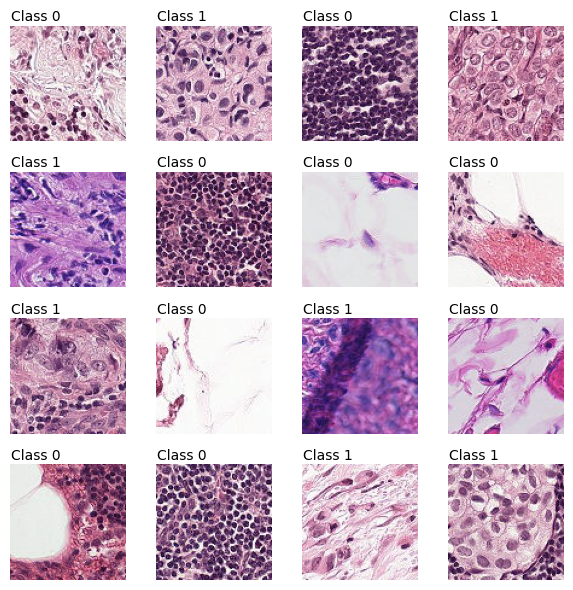

In [7]:
train_path = "./train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'./train/{row.id}')
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')

    plt.axis('off')

plt.tight_layout()
plt.show()

### Split training set for validation

In [8]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

In [9]:
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(176020, 2)
(44005, 2)


,id,label
169632,05afcb247924970d9c7c17ccf956db20f8b626f3.tif,0
48553,55e47dbf379817bf65ba25ac599a639638a44bbb.tif,0
165988,836b2171417da27f68be363c80fd53e0319f875f.tif,1
48724,8ff04d223f6ce6d707565e9cf19ca4f040e6b8d5.tif,0
173841,af80e9b4701f43eb0354dc58088186a1a76f897a.tif,1


### Generate image data using keras image library function ImageDataGenerator


In [38]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

In [39]:
BATCH_SIZE = 64

#### Load the train dataset into the ImageDataGenerator
#### Initially we choose a target size of 96,96,3 (1/2 of the original image)

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

#### Load the valid dataset into the ImageDataGenerator

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [40]:
print(len(train_loader))
print(len(valid_loader))

2751
688


In [41]:
print(valid_loader[0][0].shape)

(64, 96, 96, 3)


## Build the Sequential model and add the convolutional layers
---




We will next create a model using the following layers:


1.   3 sets of Convolution 2D layers with "relu" activation function with 32, 64 and 96 filters in each layer
2.   Each set of Conv2D layers is following by a layer of Batch Normalization (gives better results than Max Pooling
3.   Flatten the output into a 2 dimensional matrix
4.   Drop 20% of the parameters
5.   Apply a Dense layer with a softmax activation function to execute the classification function

In [57]:
np.random.seed(1)
tf.random.set_seed(1)
model = keras.Sequential(name='nn')
model.add(layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=3, strides=2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(96, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))
model.build(input_shape=train_loader[0][0].shape)

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (64, 96, 96, 32)          896       
                                                                 
 batch_normalization_18 (Ba  (64, 96, 96, 32)          128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (64, 47, 47, 64)          18496     
                                                                 
 batch_normalization_19 (Ba  (64, 47, 47, 64)          256       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (64, 45, 45, 96)          55392     
                                                                 
 batch_normalization_20 (Ba  (64, 45, 45, 96)          384      

In [59]:

history = model.fit(train_loader,steps_per_epoch=100, epochs=10, validation_data=valid_loader, validation_steps=len(valid_loader)/128)

Epoch 1/10
100/100 [==============================] - 13s 92ms/step - loss: 2.0971 - accuracy: 0.7222 - val_loss: 3.8056 - val_accuracy: 0.3776
Epoch 2/10
100/100 [==============================] - 13s 128ms/step - loss: 1.9716 - accuracy: 0.7498 - val_loss: 2.8691 - val_accuracy: 0.5156
Epoch 3/10
100/100 [==============================] - 13s 132ms/step - loss: 2.0101 - accuracy: 0.7486 - val_loss: 4.0929 - val_accuracy: 0.4948
Epoch 4/10
100/100 [==============================] - 10s 95ms/step - loss: 1.9508 - accuracy: 0.7536 - val_loss: 3.7790 - val_accuracy: 0.5495
Epoch 5/10
100/100 [==============================] - 13s 133ms/step - loss: 1.8212 - accuracy: 0.7586 - val_loss: 2.5222 - val_accuracy: 0.6953
Epoch 6/10
100/100 [==============================] - 12s 119ms/step - loss: 1.6984 - accuracy: 0.7752 - val_loss: 1.4401 - val_accuracy: 0.7422
Epoch 7/10
100/100 [==============================] - 13s 127ms/step - loss: 1.6701 - accuracy: 0.7728 - val_loss: 2.7964 - val_accu

**Test the model accuracy against the sample submission dataset**

In [60]:
df_samples = pd.read_csv('./sample_submission.csv')
test_data = df_samples.astype(str)
#test_data = test_data.sample(1000)
test_data['id'] += '.tif'


In [61]:
test = './test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=64,
)

Found 57458 validated image filenames belonging to 1 classes.


In [62]:
loss, acc = model.evaluate(test_generator,steps=len(test_data)/100)
print('test loss is {}'.format(loss))
print('test Accuracy is {}'.format(acc))

574/574 [==============================] - 56s 97ms/step - loss: 58.1775 - accuracy: 1.0000
test loss is 58.177459716796875
test Accuracy is 1.0


**The model performs quite well on the test data with 100% accuracy**

#### Copy the predicted values into output file for submission

In [63]:
test_results = model.predict(test_generator)

898/898 [==============================] - 61s 68ms/step


In [64]:
predictions = np.argmax(test_results, axis=1)
submit_ds = pd.DataFrame({'id': test_data.id,
                          'label': predictions})
submit_ds.to_csv('submission.csv', index=False)
!cp submission.csv '/gdrive/MyDrive/kaggle/'

### Plot the model accuracy and loss by epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


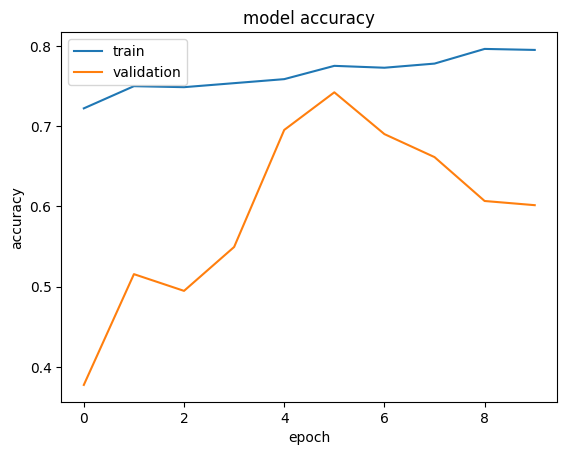

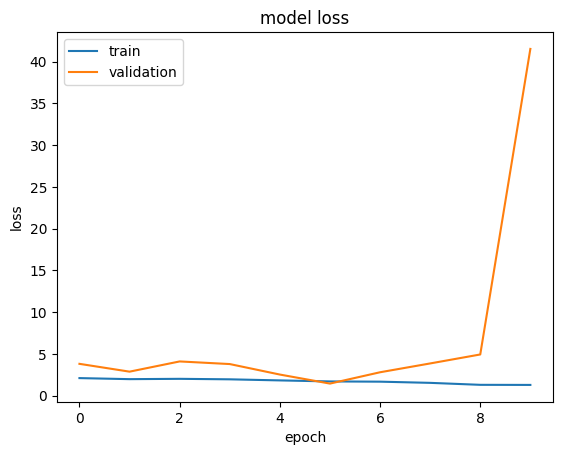

In [65]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Use model VGG19 from keras.applications

We will next use a 2nd approach using a built-in model from keras.applications library (VGG19) and add the following layers to it's output:


1.   Batch Normalization
2.   Flatten the matrix into 2 dimensions
3.   Drop 20% of the paramters
4.   Dense layer with `softmax` activation function for the final classification




In [68]:
np.random.seed(1)
tf.random.set_seed(1)

base_model = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(96,96,3))
model2 = keras.Sequential(name='model2_VGG19')
model2.add(base_model)
model2.add(layers.BatchNormalization())
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(2, activation='softmax'))
model2.build(input_shape=valid_loader[0][0].shape)
model2.trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "model2_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 batch_normalization_22 (Ba  (None, 3, 3, 512)         2048      
 tchNormalization)                                               
                                                                 
 flatten_10 (Flatten)        (None, 4608)              0         
                                                                 
 dropout_3 (Dropout)         (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 2)                 9218      
                                                                 
Total params: 20035650 (76.43 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20035650 (76.43 MB)
____________

**Next we train the new model on the training dataset and test the model against the test dataset**

In [69]:
model2.fit(train_loader,steps_per_epoch=100, epochs=10, validation_data=valid_loader, validation_steps=len(valid_loader)/128)

Epoch 1/10
100/100 [==============================] - 14s 132ms/step - loss: 0.7179 - accuracy: 0.6158 - val_loss: 0.7074 - val_accuracy: 0.6016
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - loss: 0.7270 - accuracy: 0.5994 - val_loss: 0.7024 - val_accuracy: 0.6042
Epoch 3/10
100/100 [==============================] - 11s 105ms/step - loss: 0.7277 - accuracy: 0.5966 - val_loss: 0.6851 - val_accuracy: 0.6224
Epoch 4/10
100/100 [==============================] - 11s 111ms/step - loss: 0.7183 - accuracy: 0.6134 - val_loss: 0.6936 - val_accuracy: 0.6146
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.7213 - accuracy: 0.6069 - val_loss: 0.6861 - val_accuracy: 0.6641
Epoch 6/10
100/100 [==============================] - 12s 124ms/step - loss: 0.7217 - accuracy: 0.6008 - val_loss: 0.6967 - val_accuracy: 0.6458
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.7226 - accuracy: 0.6016 - val_loss: 0.6982 - val_ac

In [70]:
loss2, acc2 = model2.evaluate(test_generator,steps=len(test_data)/100)
print('test loss is {}'.format(loss2))
print('test Accuracy is {}'.format(acc2))

574/574 [==============================] - 50s 86ms/step - loss: 1.0370 - accuracy: 0.9356
test loss is 1.0370198488235474
test Accuracy is 0.9356250166893005


**The results are good at 93% accuracy, however is not ass good as the custom 1st model built**